# 1. Config

In [832]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [833]:
pd.set_option("display.max_columns", None)
import gc
gc.enable()

# 2. Essential Functions

In [834]:
def check_missing_value_col(df, n):
    null_percent_col = (df.isnull().sum() / df.shape[0]) * 100
    df_null_percent_col = pd.DataFrame(null_percent_col).reset_index().rename(columns={0: 'missing_percent', 'index': 'feature'})
    df_null_percent_col = df_null_percent_col.sort_values('missing_percent', ascending=False)
    return df_null_percent_col[df_null_percent_col['missing_percent'] > n]
def statitic_missing_value_col(df):
    for m in [0,5,10,30,40,50,100]:
        print(f"The number of colums have the null percentage > {m}",check_missing_value_col(df, m).shape[0])
def check_missing_value_row(df, n):
    null_percent_row = (df.isnull().sum(axis=1) / df.shape[1]) * 100
    df_null_percent_row = pd.DataFrame(null_percent_row, columns=['missing_percent']).reset_index().rename(columns={'index': 'application'})
    return df_null_percent_row[df_null_percent_row['missing_percent'] > n]
def statitic_missing_value_row(df):
    for m in [0,5, 10, 15, 50, 100]:
        print(f"The number of rows with the null percentage > {m}: ", check_missing_value_row(df, m).shape[0])

In [835]:
def check_imbalance(data, column, threshold=0.8):
    value_counts = data[column].value_counts(normalize=True)  # Use normalize=True to get percentages
    max_percentage = value_counts.max()  # Maximum percentage
    most_frequent_value = value_counts.idxmax()  # Value with the maximum frequency
    
    if max_percentage > threshold:
        print(f"Column '{column}' is imbalanced. The most frequent value '{most_frequent_value}' appears in {max_percentage*100:.2f}% of the data.")
        return True
    else:
        return None

In [836]:
def convert_days(data, features, t = 12, rounding = True, replace = False, time = 'MONTH'):
    for var in features:
        if replace == True:
            if rounding == True:
                data[var] = abs(data[var])//t
            else:
                data[var] = abs(data[var])/t
        else:
            if rounding == True:
                data[ time + "_" + str(var)] = abs(data[var])//t
            else:
                data[time + "_" + str(var)] = abs(data[var])/t
    return data

In [837]:
def _tbl_dtype(data):
    sum_dtype = pd.DataFrame(data.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

In [838]:
def identify_columns_with_outliers(data, method='iqr'):
    columns_with_outliers = []

    for column in data.select_dtypes(include='number').columns:
        if method == 'iqr':
            # Interquartile Range (IQR) method
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            if ((data[column] < lower_bound) | (data[column] > upper_bound)).any():
                columns_with_outliers.append(column)
        elif method == 'std':
            # Standard Deviation method
            mean = data[column].mean()
            std_dev = data[column].std()
            lower_bound = mean - 3 * std_dev
            upper_bound = mean + 3 * std_dev
            if ((data[column] < lower_bound) | (data[column] > upper_bound)).any():
                columns_with_outliers.append(column)
    
    return columns_with_outliers

def plot_boxplots_for_outlier_columns(data, method='iqr'):
    columns_with_outliers = identify_columns_with_outliers(data, method)

    if not columns_with_outliers:
        print("No columns with outliers found.")
        return

    num_columns = len(columns_with_outliers)
    num_rows = (num_columns + 2) // 3  # Arrange in a grid with 3 columns per row

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    for idx, column in enumerate(columns_with_outliers):
        sns.boxplot(x=data[column], ax=axes[idx])
        axes[idx].set_title(f'Box Plot for {column}')
        axes[idx].set_xlabel('Value')

    for idx in range(num_columns, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [839]:
def encode_column(data, columns, encoding_type='label', target_column=None):
    for column in columns:
        if encoding_type == 'label':
            # Label Encoding
            le = LabelEncoder()
            data.loc[:, column] = le.fit_transform(data[column])
        elif encoding_type == 'onehot':
            # One-Hot Encoding
            data = pd.get_dummies(data, columns=[column], drop_first=False)
        elif encoding_type == 'target':
            if target_column is None:
                raise ValueError("target_column is required for target encoding.")
            # Target Encoding
            mean_encoded = data.groupby(column)[target_column].mean()
            data.loc[:, column] = data[column].map(mean_encoded)
        else:
            raise ValueError(f"Invalid encoding type: {encoding_type}. Choose 'label', 'onehot', or 'target'.")

    return data


In [840]:
def create_transforms(data, columns, transform_type='log', replace=False, boxcox_lambda=None, min_max_range=(0, 1)):
    scaler = None
    
    for var in columns:
        if transform_type == 'log':
            transformed = np.log(data[var].abs() + 1)
        
        elif transform_type == 'boxcox':
            if (data[var] <= 0).any():
                raise ValueError(f"Box-Cox transform yêu cầu tất cả giá trị trong cột {var} phải dương.")
            transformed, lambda_used = boxcox(data[var], lmbda=boxcox_lambda)
            print(f"Box-Cox lambda cho cột '{var}': {lambda_used}")
        
        elif transform_type == 'minmax':
            if scaler is None:
                scaler = MinMaxScaler(feature_range=min_max_range)
            transformed = scaler.fit_transform(data[[var]])
            transformed = transformed.flatten()
        
        elif transform_type == 'ztransform':
            if scaler is None:
                scaler = StandardScaler()
            transformed = scaler.fit_transform(data[[var]])
            transformed = transformed.flatten()
        
        else:
            raise ValueError(f"Invalid transform type: {transform_type}. Choose 'log', 'boxcox', 'minmax', or 'ztransform'.")

        if replace:
            data.loc[:, var] = transformed
        else:
            data[var + f"_{transform_type.upper()}"] = transformed

    return data

# 3. Data Import

In [841]:
train = pd.read_csv('dseb63_application_train.csv')
train.shape

(246009, 123)

In [842]:
test = pd.read_csv('dseb63_application_test.csv')
test.shape

(61502, 122)

In [843]:
bureau = pd.read_csv("dseb63_bureau.csv")
bureau.shape

(1465325, 17)

In [844]:
bureau_bal = pd.read_csv("dseb63_bureau_balance.csv")
bureau_bal.shape

(27299925, 3)

In [845]:
previous= pd.read_csv('dseb63_previous_application.csv')
previous.shape

(1413701, 37)

In [846]:
poca = pd.read_csv('dseb63_POS_CASH_balance.csv')
poca.shape

(8543375, 8)

In [847]:
inst = pd.read_csv('dseb63_installments_payments.csv')
inst.shape

(7744758, 8)

In [848]:
card = pd.read_csv('dseb63_credit_card_balance.csv')
card.shape

(3227965, 23)

In [849]:
# extract target
y = train[["SK_ID_CURR", "TARGET"]]
del train["TARGET"]

In [850]:
# concatenate application data
appl = pd.concat([train, test])
# del train, test

# 4. PREPROCESSING

## 4.1. Train_test_application(appl)

In [851]:
#Chia nhóm ra EDA giải thích dễ hơn
loan_columns = ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START']
demographic_columns = ['CODE_GENDER', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'ORGANIZATION_TYPE']
asset_columns = [
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE', 'OWN_CAR_AGE', 'APARTMENTS_AVG', 
    'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 
    'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 
    'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 
    'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 
    'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 
    'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 
    'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 
    'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 
    'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 
    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 
    'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
]
behaviour_columns = [
    'NAME_TYPE_SUITE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 
    'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'
]
previous_columns = [
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 
    'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

### 4.1.1. Handling missing data

In [852]:
# amt_annuity: lượng tiền cố định cần trả mỗi năm, bị null có thể là do loại loan đó thiếu số liệu (đã check, có thể do ngẫu nhiên)
# amt_goods_price: vay tiền để mua món đồ có giá trị bao nhiêu. Bị null có thể do thiếu data hoặc do vay tiền không rõ nguyên nhân (có thể là vay tiền ít\
# hoặc ko muốn nói lí do -> ngẫu nhiên)
check_missing_value_col(appl[loan_columns],-1)

,feature,missing_percent
4,AMT_GOODS_PRICE,0.090403
3,AMT_ANNUITY,0.003902
0,SK_ID_CURR,0.000000
1,NAME_CONTRACT_TYPE,0.000000
2,AMT_CREDIT,0.000000
5,WEEKDAY_APPR_PROCESS_START,0.000000
6,HOUR_APPR_PROCESS_START,0.000000


In [853]:
# cột NAME_FAMILY_STATUS có giá trị 'Unknown', có thể sửa thành np.nan để impute
# có 1 dòng có CNT_FAM_NUMBERS (số lượng thành viên gia đình) null, số con cái và tình trạng hôn nhân cũng unknown -> np.nan
# cột OCCUPATION_TYPE (nghề nghiệp) thiếu khá nhiều, t nghĩ có thể impute bằng AMT_INCOME_TOTAL mean cho từng loại nghề nghiệp
check_missing_value_col(appl[demographic_columns],0)

,feature,missing_percent
8,OCCUPATION_TYPE,31.345545
9,CNT_FAM_MEMBERS,0.000650


In [854]:
# Thiếu có thể do ko phải ngâu nhiên, ko có cách nào xác định được nên việc muốn fill cần cân nhắc
check_missing_value_col(appl[asset_columns],0)

,feature,missing_percent
22,COMMONAREA_MODE,69.872297
8,COMMONAREA_AVG,69.872297
36,COMMONAREA_MEDI,69.872297
30,NONLIVINGAPARTMENTS_MODE,69.432963
44,NONLIVINGAPARTMENTS_MEDI,69.432963
16,NONLIVINGAPARTMENTS_AVG,69.432963
46,FONDKAPREMONT_MODE,68.386172
28,LIVINGAPARTMENTS_MODE,68.354953
42,LIVINGAPARTMENTS_MEDI,68.354953
14,LIVINGAPARTMENTS_AVG,68.354953


In [855]:
check_missing_value_col(appl[behaviour_columns],0)

,feature,missing_percent
16,EXT_SOURCE_1,56.381073
18,EXT_SOURCE_3,19.825307
0,NAME_TYPE_SUITE,0.420148
17,EXT_SOURCE_2,0.214626
19,DAYS_LAST_PHONE_CHANGE,0.000325


In [856]:
#Sẽ chỉnh lại
appl['NAME_TYPE_SUITE'].value_counts()

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64

In [857]:
# ..._30_CNT_SOCIAL_CIRCLE: 1 cái null là tất cả cái còn lại null. Có thể impute hoặc cho bằng 0 (t nghĩ nên cho = 0 vì mode = 0) hoặc imput cx đúng tại vì có thể hjko có thật
# AMT_REQ_CREDIT_BUREAU_...: cũng thế. impute hoặc cho = 0 hoặc #
# hoặc -1 in case 
check_missing_value_col(appl[previous_columns],0)

,feature,missing_percent
4,AMT_REQ_CREDIT_BUREAU_HOUR,13.501631
5,AMT_REQ_CREDIT_BUREAU_DAY,13.501631
6,AMT_REQ_CREDIT_BUREAU_WEEK,13.501631
7,AMT_REQ_CREDIT_BUREAU_MON,13.501631
8,AMT_REQ_CREDIT_BUREAU_QRT,13.501631
9,AMT_REQ_CREDIT_BUREAU_YEAR,13.501631
0,OBS_30_CNT_SOCIAL_CIRCLE,0.332021
1,DEF_30_CNT_SOCIAL_CIRCLE,0.332021
2,OBS_60_CNT_SOCIAL_CIRCLE,0.332021
3,DEF_60_CNT_SOCIAL_CIRCLE,0.332021


In [858]:
##### FEATURE REMOVAL
drops_cols = ['APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 
         'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
         'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
         'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'COMMONAREA_MODE','ELEVATORS_MODE', 'ENTRANCES_MODE', 
         'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 
         'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'TOTALAREA_MODE',  'YEARS_BEGINEXPLUATATION_MODE']
appl = appl.drop(columns = drops_cols )
# appl.drop(columns = drops).shape

In [859]:
#Cột trên 50 drop, ưu tiên giữ avg mà mode rác. Dòng kbiet, trừ cái ext_source 1
appl.shape

(307511, 94)

In [860]:
appl = appl.drop(appl.columns[0], axis=1)
appl.shape

(307511, 93)

### 4.1.2. Check duplicate

In [861]:
appl[appl.duplicated('SK_ID_CURR')].shape[0]

0

### 4.1.3. Check imbalance

In [862]:
train = appl[appl["SK_ID_CURR"].isin(y["SK_ID_CURR"]) == True]
test  = appl[appl["SK_ID_CURR"].isin(y["SK_ID_CURR"]) == False]

In [863]:
train.loc[:, 'TARGET'] = y['TARGET']

C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\804434086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, 'TARGET'] = y['TARGET']


In [864]:
table_dtype = _tbl_dtype(train)
table_dtype

,Data Type
TARGET,int64
FLAG_DOCUMENT_11,int64
REGION_RATING_CLIENT,int64
REGION_RATING_CLIENT_W_CITY,int64
FLAG_DOCUMENT_10,int64
...,...
WALLSMATERIAL_MODE,object
HOUSETYPE_MODE,object
FONDKAPREMONT_MODE,object
NAME_EDUCATION_TYPE,object


In [865]:
dtypes_object = table_dtype[table_dtype['Data Type'] == 'object'].index.tolist()

In [866]:
def _per_categorical(col):
    tbl_per = pd.pivot_table(train[['TARGET', col]], index = ['TARGET'], columns = [col], aggfunc = len)
    per_categorical = (tbl_per.iloc[0, :]/tbl_per.iloc[1, :]).sort_values(ascending = True)
    print(per_categorical)
    print('-------------------------------------\n')
    return per_categorical

for col in dtypes_object:
    _per_categorical(col)

FLAG_OWN_REALTY
N    10.953880
Y    11.573079
dtype: float64
-------------------------------------

FLAG_OWN_CAR
N    10.718497
Y    12.887508
dtype: float64
-------------------------------------

CODE_GENDER
M       8.851323
F      13.280572
XNA          NaN
dtype: float64
-------------------------------------

NAME_TYPE_SUITE
Other_B             9.306569
Other_A             9.803030
Group of people    10.000000
Unaccompanied      11.241577
Spouse, partner    11.668985
Children           11.975248
Family             12.174590
dtype: float64
-------------------------------------

NAME_INCOME_TYPE
Maternity leave          1.000000
Unemployed               2.166667
Working                  9.474501
Commercial associate    12.214796
State servant           16.141026
Pensioner               17.479566
Businessman                   NaN
Student                       NaN
dtype: float64
-------------------------------------

WEEKDAY_APPR_PROCESS_START
TUESDAY      11.013370
FRIDAY       11.1660

In [867]:
# Nhóm các giá trị rate gần bằng nhau vào 1 nhóm theo schedule_div.
def _devide_group(col, schedule_div = None, n_groups = 3, *kwargs):
    cols = []
    tbl_per_cat = _per_categorical(col)
    
    if schedule_div is None:
        n_cats = len(tbl_per_cat)
        n_val_incat = int(n_cats/n_groups)
        n_odd = n_cats - n_groups*n_val_incat

        for i in range(n_groups):
            if i == n_groups - 1:
                el = tbl_per_cat[(n_val_incat*i):(n_val_incat*(i+1)+n_odd)].index.tolist()
            else:
                el = tbl_per_cat[(n_val_incat*i):n_val_incat*(i+1)].index.tolist()    
            cols.append(el)
    else:
        idx = 0
        for n_cols in schedule_div:
            el_cols = tbl_per_cat[idx:(idx+n_cols)].index.tolist()
            cols.append(el_cols)
            idx += n_cols
                
    return cols

In [868]:
cols_OCCUPATION_TYPE = _devide_group(col = 'OCCUPATION_TYPE', schedule_div = [1, 7, 9, 1])
cols_OCCUPATION_TYPE

OCCUPATION_TYPE
Low-skill Laborers        4.814035
Waiters/barmen staff      7.851240
Drivers                   7.972875
Security staff            8.364111
Cooking staff             8.432596
Laborers                  8.459020
Sales staff               9.394320
Cleaning staff            9.396648
Realty agents            10.461538
IT staff                 12.700000
Private service staff    13.486301
Medicine staff           13.851852
Secretaries              14.573529
Core staff               14.621545
Managers                 14.820276
High skill tech staff    15.422182
HR staff                 15.555556
Accountants              19.437500
dtype: float64
-------------------------------------



[['Low-skill Laborers'],
 ['Waiters/barmen staff',
  'Drivers',
  'Security staff',
  'Cooking staff',
  'Laborers',
  'Sales staff',
  'Cleaning staff'],
 ['Realty agents',
  'IT staff',
  'Private service staff',
  'Medicine staff',
  'Secretaries',
  'Core staff',
  'Managers',
  'High skill tech staff',
  'HR staff'],
 ['Accountants']]

In [869]:
cols_ORGANIZATION_TYPE = _devide_group(col = 'ORGANIZATION_TYPE')
cols_ORGANIZATION_TYPE

ORGANIZATION_TYPE
Transport: type 3          5.378378
Restaurant                 7.202247
Industry: type 1           7.505155
Construction               7.528302
Realtor                    8.085714
Cleaning                   8.318182
Mobile                     8.481481
Industry: type 4           8.520000
Industry: type 3           8.549451
Agriculture                8.558252
Self-employed              8.820857
Trade: type 3              8.918149
Trade: type 1              9.000000
Security                   9.189723
Trade: type 7              9.601019
Transport: type 4          9.626536
Business Entity Type 3     9.706091
Industry: type 8          10.000000
Postal                    10.090909
Industry: type 13         10.200000
Industry: type 11         10.395833
Business Entity Type 2    10.486450
Advertising               11.107143
Business Entity Type 1    11.189873
Industry: type 2          11.433333
Industry: type 7          11.716049
Religion                  11.800000
Other     

[['Transport: type 3',
  'Restaurant',
  'Industry: type 1',
  'Construction',
  'Realtor',
  'Cleaning',
  'Mobile',
  'Industry: type 4',
  'Industry: type 3',
  'Agriculture',
  'Self-employed',
  'Trade: type 3',
  'Trade: type 1',
  'Security',
  'Trade: type 7',
  'Transport: type 4',
  'Business Entity Type 3',
  'Industry: type 8',
  'Postal'],
 ['Industry: type 13',
  'Industry: type 11',
  'Business Entity Type 2',
  'Advertising',
  'Business Entity Type 1',
  'Industry: type 2',
  'Industry: type 7',
  'Religion',
  'Other',
  'Housing',
  'Transport: type 2',
  'Industry: type 6',
  'Telecom',
  'Services',
  'Kindergarten',
  'Legal Services',
  'Industry: type 9',
  'Insurance',
  'Trade: type 2'],
 ['Government',
  'Medicine',
  'Industry: type 5',
  'Emergency',
  'Hotel',
  'Electricity',
  'School',
  'XNA',
  'Transport: type 1',
  'Bank',
  'Military',
  'Culture',
  'Police',
  'University',
  'Security Ministries',
  'Industry: type 10',
  'Trade: type 6',
  'Ind

In [870]:
def _map_lambda_cats(cols_list, colname, x): 
    cats = list(map(lambda x:colname + '_' + str(x), np.arange(len(cols_list)).tolist()))
    for i in range(len(cols_ORGANIZATION_TYPE)):
        if x in cols_list[i]:
            return cats[i]
        
def _map_cats(cols_list, colname, dataset):                    
    return list(map(lambda x: _map_lambda_cats(cols_list, colname, x), 
                    dataset[colname]))


In [871]:
train['ORGANIZATION_TYPE'] = _map_cats(cols_ORGANIZATION_TYPE, 'ORGANIZATION_TYPE', train)
pd.Series.unique(train['ORGANIZATION_TYPE'])

C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\2428270798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ORGANIZATION_TYPE'] = _map_cats(cols_ORGANIZATION_TYPE, 'ORGANIZATION_TYPE', train)


array(['ORGANIZATION_TYPE_2', 'ORGANIZATION_TYPE_0',
       'ORGANIZATION_TYPE_1'], dtype=object)

In [872]:
test['ORGANIZATION_TYPE'] = _map_cats(cols_ORGANIZATION_TYPE, 'ORGANIZATION_TYPE', test)
pd.Series.unique(test['ORGANIZATION_TYPE'])

C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\1465601365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ORGANIZATION_TYPE'] = _map_cats(cols_ORGANIZATION_TYPE, 'ORGANIZATION_TYPE', test)


array(['ORGANIZATION_TYPE_0', 'ORGANIZATION_TYPE_2',
       'ORGANIZATION_TYPE_1'], dtype=object)

In [873]:
train['OCCUPATION_TYPE'] = _map_cats(cols_OCCUPATION_TYPE, 'OCCUPATION_TYPE', train)
test['OCCUPATION_TYPE'] = _map_cats(cols_OCCUPATION_TYPE, 'OCCUPATION_TYPE', test)

C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\227609430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['OCCUPATION_TYPE'] = _map_cats(cols_OCCUPATION_TYPE, 'OCCUPATION_TYPE', train)
C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\227609430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['OCCUPATION_TYPE'] = _map_cats(cols_OCCUPATION_TYPE, 'OCCUPATION_TYPE', test)


In [874]:
for col in dtypes_object:
    _per_categorical(col)

FLAG_OWN_REALTY
N    10.953880
Y    11.573079
dtype: float64
-------------------------------------

FLAG_OWN_CAR
N    10.718497
Y    12.887508
dtype: float64
-------------------------------------

CODE_GENDER
M       8.851323
F      13.280572
XNA          NaN
dtype: float64
-------------------------------------

NAME_TYPE_SUITE
Other_B             9.306569
Other_A             9.803030
Group of people    10.000000
Unaccompanied      11.241577
Spouse, partner    11.668985
Children           11.975248
Family             12.174590
dtype: float64
-------------------------------------

NAME_INCOME_TYPE
Maternity leave          1.000000
Unemployed               2.166667
Working                  9.474501
Commercial associate    12.214796
State servant           16.141026
Pensioner               17.479566
Businessman                   NaN
Student                       NaN
dtype: float64
-------------------------------------

WEEKDAY_APPR_PROCESS_START
TUESDAY      11.013370
FRIDAY       11.1660

In [875]:
#4 instances of 'XNA' in code gender
train['CODE_GENDER'] = train['CODE_GENDER'].replace('XNA', np.random.choice(['F', 'M']))
#XNA 2 in NAME_FAMILY_STATUS
train['NAME_FAMILY_STATUS'] = train['NAME_FAMILY_STATUS'].replace('Unknown', np.random.choice(['Married', 'Civil marriage', 'Single / not married', 'Widow','Separated']))
test['CODE_GENDER'] = test['CODE_GENDER'].replace('XNA', np.random.choice(['F', 'M']))
#XNA 2 in NAME_FAMILY_STATUS
test['NAME_FAMILY_STATUS'] = test['NAME_FAMILY_STATUS'].replace('Unknown', np.random.choice(['Married', 'Civil marriage', 'Single / not married', 'Widow','Separated']))

C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\2286356166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['CODE_GENDER'] = train['CODE_GENDER'].replace('XNA', np.random.choice(['F', 'M']))
C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\2286356166.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['NAME_FAMILY_STATUS'] = train['NAME_FAMILY_STATUS'].replace('Unknown', np.random.choice(['Married', 'Civil marriage', 'Single / not married', 'Widow','Separated']))
C:\Users\nn200\AppData\Loc

### 4.1.4. Detecting and treating outliers

<Axes: >

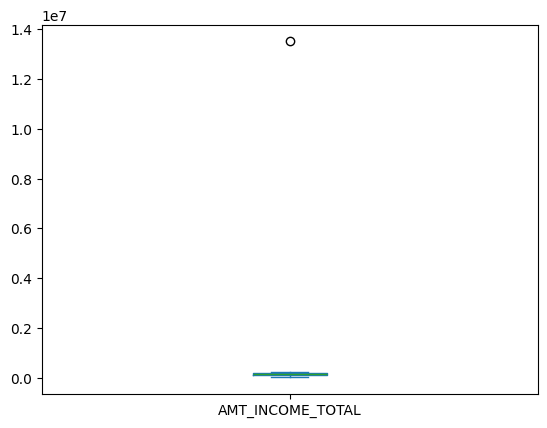

In [876]:
train['AMT_INCOME_TOTAL'].describe().plot.box()

In [877]:
train['AMT_INCOME_TOTAL'].describe()

count    2.460090e+05
mean     1.684589e+05
std      1.045297e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.462500e+05
75%      2.025000e+05
max      1.350000e+07
Name: AMT_INCOME_TOTAL, dtype: float64

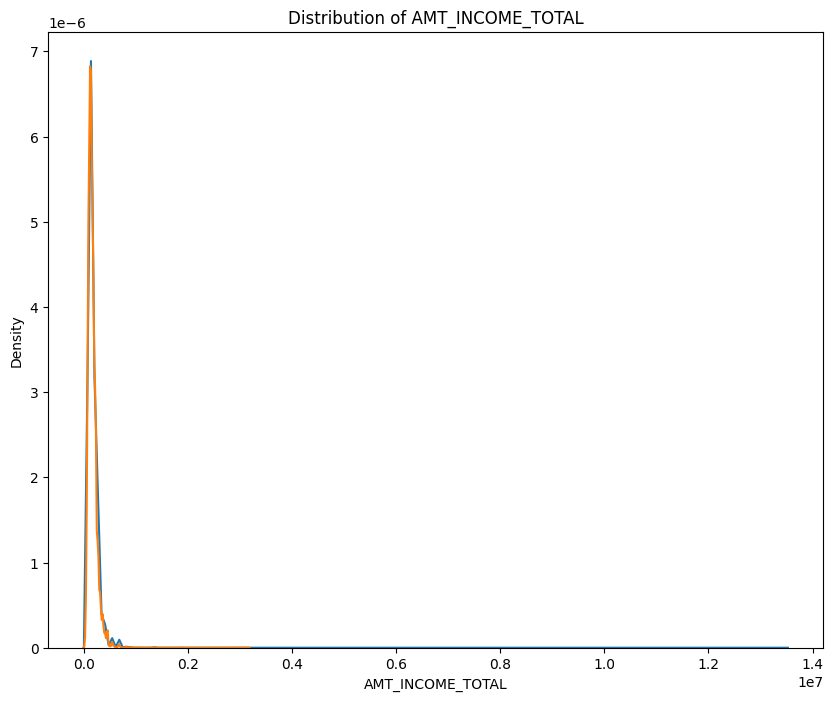

In [878]:
def _plot_density(colname):
    plt.figure(figsize = (10, 8))
    sns.kdeplot(train[colname][train['TARGET'] == 0], label = 'Target = 0')
    sns.kdeplot(train[colname][train['TARGET'] == 1], label = 'Target = 1')
    plt.xlabel(colname)
    plt.ylabel('Density')
    plt.title('Distribution of %s'%colname)

_plot_density('AMT_INCOME_TOTAL')

In [879]:
def _zoom_3sigma(col, dataset, dataset_apl):

    xs = dataset[col]
    mu = xs.mean()
    sigma = xs.std()
    low =  mu - 3*sigma
#     low =  0 if low < 0 else low
    high = mu + 3*sigma
    
    def _value(x):
        if x < low: return low
        elif x > high: return high
        else: return x
    xapl = dataset_apl[col]    
    xnew = list(map(lambda x: _value(x), xapl))
    n_low = len([i for i in xnew if i == low])
    n_high = len([i for i in xnew if i == high])
    n = len(xapl)
    print('Percentage of low: {:.2f}{}'.format(100*n_low/n, '%'))
    print('Percentage of high: {:.2f}{}'.format(100*n_high/n, '%'))
    print('Low value: {:.2f}'.format(low))
    print('High value: {:.2f}'.format(high))
    return xnew


In [880]:
# Thống kê các giá trị khác biệt trong toàn bộ các biến. có trên 500 là biến liên tục, sử dụng với 3 sigma(kha nang cao la pp chuan)
def _count_unique(x):
    return pd.Series.nunique(x)

tbl_dis_val = train.apply(_count_unique).sort_values(ascending = False)
tbl_dis_val[tbl_dis_val > 500]

SK_ID_CURR                246009
EXT_SOURCE_2              108873
EXT_SOURCE_1               94619
DAYS_BIRTH                 17418
DAYS_REGISTRATION          15367
AMT_ANNUITY                13150
DAYS_EMPLOYED              12078
DAYS_ID_PUBLISH             6140
AMT_CREDIT                  5267
LIVINGAREA_AVG              5064
DAYS_LAST_PHONE_CHANGE      3737
BASEMENTAREA_AVG            3692
LANDAREA_AVG                3415
NONLIVINGAREA_AVG           3146
COMMONAREA_AVG              3032
APARTMENTS_AVG              2257
AMT_INCOME_TOTAL            2185
LIVINGAPARTMENTS_AVG        1801
AMT_GOODS_PRICE              883
EXT_SOURCE_3                 807
dtype: int64

In [881]:
cols_3sigma = tbl_dis_val[tbl_dis_val > 500].index.tolist()
# Loại bỏ biến key là SK_ID_CURR ra khỏi danh sách:
cols_3sigma = cols_3sigma[1:]

In [882]:
# Loại bỏ các outlier bằng 3 sigma
for col in cols_3sigma:
    print(col)
    train[col] = _zoom_3sigma(col, train, train) 
    print('------------------------\n')

EXT_SOURCE_2
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -0.06
High value: 1.09
------------------------

EXT_SOURCE_1


C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\3576846627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = _zoom_3sigma(col, train, train)


Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -0.13
High value: 1.13
------------------------

DAYS_BIRTH
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -29122.74
High value: -2955.15
------------------------

DAYS_REGISTRATION
Percentage of low: 0.24%
Percentage of high: 0.00%
Low value: -15549.40
High value: 5578.95
------------------------

AMT_ANNUITY
Percentage of low: 0.00%
Percentage of high: 0.96%
Low value: -16411.67
High value: 70652.14
------------------------

DAYS_EMPLOYED
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -360066.52
High value: 487771.74
------------------------

DAYS_ID_PUBLISH
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -7520.22
High value: 1534.27
------------------------

AMT_CREDIT
Percentage of low: 0.00%
Percentage of high: 1.06%
Low value: -609653.15
High value: 1808935.12
------------------------

LIVINGAREA_AVG
Percentage of low: 0.00%
Percentage of high: 1.03%
Low value: -0.22
High val

In [883]:
for col in cols_3sigma:
    print(col)
    test[col] = _zoom_3sigma(col, test, test) 
    print('------------------------\n')

EXT_SOURCE_2
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -0.06
High value: 1.09


------------------------

EXT_SOURCE_1
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -0.14
High value: 1.14


C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\1987965799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = _zoom_3sigma(col, test, test)


------------------------

DAYS_BIRTH
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -29153.86
High value: -2904.52
------------------------

DAYS_REGISTRATION
Percentage of low: 0.27%
Percentage of high: 0.00%
Low value: -15576.37
High value: 5596.95
------------------------

AMT_ANNUITY
Percentage of low: 0.00%
Percentage of high: 0.96%
Low value: -16216.00
High value: 70339.84
------------------------

DAYS_EMPLOYED
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -359798.14
High value: 487127.70
------------------------

DAYS_ID_PUBLISH
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -7531.90
High value: 1533.67
------------------------

AMT_CREDIT
Percentage of low: 0.00%
Percentage of high: 1.32%
Low value: -603572.81
High value: 1796704.90
------------------------

LIVINGAREA_AVG
Percentage of low: 0.00%
Percentage of high: 1.07%
Low value: -0.22
High value: 0.44
------------------------

DAYS_LAST_PHONE_CHANGE
Percentage of low: 0.20%
Pe

<Axes: >

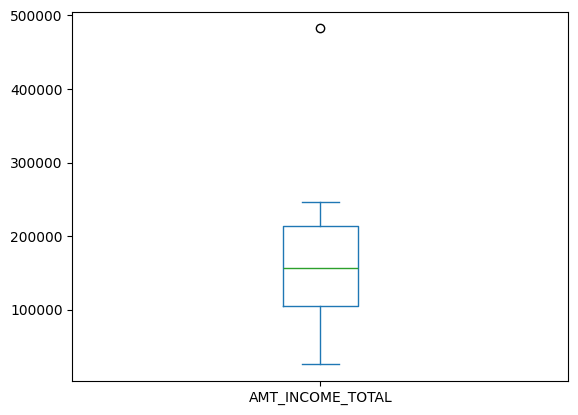

In [884]:
train['AMT_INCOME_TOTAL'].describe().plot.box()

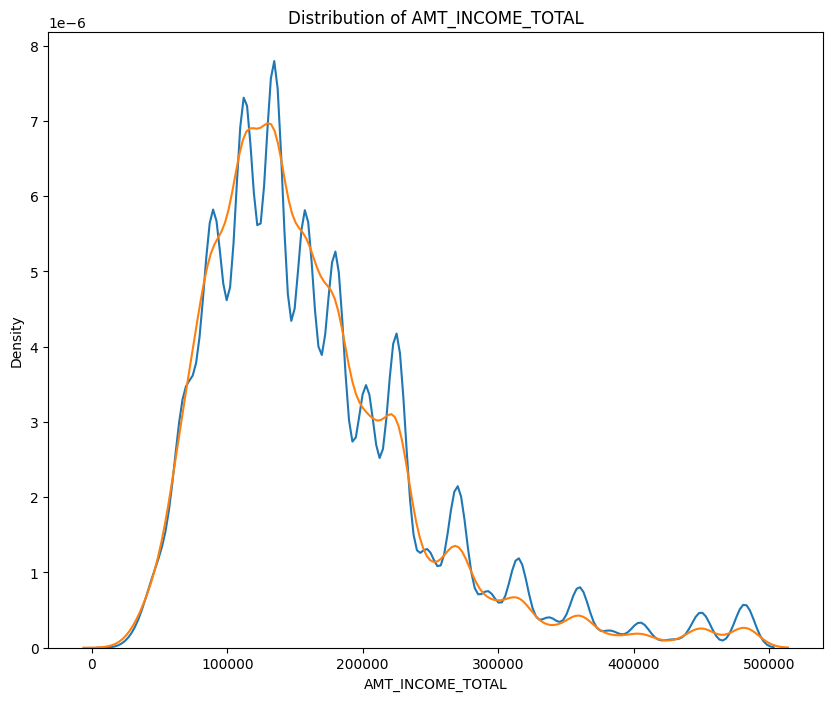

In [885]:
_plot_density('AMT_INCOME_TOTAL')

In [886]:
tbl_dis_val[tbl_dis_val > 500]

SK_ID_CURR                246009
EXT_SOURCE_2              108873
EXT_SOURCE_1               94619
DAYS_BIRTH                 17418
DAYS_REGISTRATION          15367
AMT_ANNUITY                13150
DAYS_EMPLOYED              12078
DAYS_ID_PUBLISH             6140
AMT_CREDIT                  5267
LIVINGAREA_AVG              5064
DAYS_LAST_PHONE_CHANGE      3737
BASEMENTAREA_AVG            3692
LANDAREA_AVG                3415
NONLIVINGAREA_AVG           3146
COMMONAREA_AVG              3032
APARTMENTS_AVG              2257
AMT_INCOME_TOTAL            2185
LIVINGAPARTMENTS_AVG        1801
AMT_GOODS_PRICE              883
EXT_SOURCE_3                 807
dtype: int64

### 4.1.5 Feature Engineering

In [887]:
#Chuyển từ ngày thành năm.[nên scale về day hết, hay month, hay year, v để tách lẻ có sao k.] 
train = convert_days(train, ['DAYS_BIRTH','DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE'], t=30, rounding=False, replace=False, time = 'MONTH')
test = convert_days(test, ['DAYS_BIRTH','DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE'], t=30, rounding=False, replace=False, time = 'MONTH')
train = train.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE'], axis=1)
test = test.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE'], axis=1)

C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\3216934054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[time + "_" + str(var)] = abs(data[var])/t
C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\3216934054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[time + "_" + str(var)] = abs(data[var])/t
C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\3216934054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [888]:
train.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,YEARS_BUILD_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_CURR,TARGET,MONTH_DAYS_BIRTH,MONTH_DAYS_EMPLOYED,MONTH_DAYS_REGISTRATION,MONTH_DAYS_ID_PUBLISH,MONTH_DAYS_LAST_PHONE_CHANGE
count,246009.000000,246009.000000,2.460090e+05,245999.000000,2.457850e+05,246009.000000,83821.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246008.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,107484.000000,2.454800e+05,197185.000000,121025.000000,101993.000000,125927.000000,82325.000000,74079.000000,114800.000000,122060.000000,123476.000000,79054.000000,99879.000000,77812.000000,122421.000000,75140.000000,110065.000000,82325.000000,245204.000000,245204.000000,245204.000000,245204.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,212798.000000,212798.000000,212798.000000,212798.000000,212798.000000,212798.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246009.000000,246008.000000
mean,0.416229,166181.070030,5.963166e+05,26951.601799,5.352792e+05,0.020855,12.042293,0.999996,0.819787,0.198928,0.998114,0.280665,0.056961,2.152637,2.052616,2.031682,12.063372,0.015227,0.050921,0.040686,0.078363,0.230142,0.179148,0.502462,5.143854e-01,0.511034,0.114519,0.086020,0.977713,0.752876,0.041277,0.079023,0.149660,0.226512,0.232112,0.063538,0.098228,0.104201,0.008882,0.025228,0.760014,1.421837,0.143154,1.404789,0.100113,0.000033,0.709885,0.000073,0.015154,0.088025,0.000195,0.081074,0.003919,0.000016,0.003902,0.000004,0.003451,0.002947,0.001163,0.009963,0.000244,0.008130,0.000581,0.000496,0.000309,0.006480,0.006729,0.034211,0.266647,0.266920,1.901127,153580.509542,0.080794,534.631545,2258.690282,166.080069,99.765817,32.076719
std,0.720664,83476.417885,3.907345e+05,13709.186234,3.562087e+05,0.013818,11.914722,0.002016,0.384365,0.399194,0.043388,0.449325,0.231769,0.908735,0.509004,0.502704,3.268045,0.122455,0.219837,0.197561,0.268742,0.420924,0.383477,0.210813,1.910533e-01,0.194837,0.094549,0.068453,0.059673,0.113137,0.054734,0.134525,0.099801,0.144689,0.161454,0.063517,0.079530,0.095188,0.048397,0.047514,0.110012,2.415515,0.447389,2.394177,0.363496,0.005702,0.453816,0.008554,0.122165,0.283332,0.013967,0.272950,0.062476,0.004032,0.062346,0.002016,0.058645,0.054207,0.034077,0.099317,0.015615,0.089798,0.024103,0.022264,0.017574,0.084239,0.106693,0.204336,0.911957,0.834132,1.870269,88764.127645,0.272519,145.375516,4649.149573,117.061245,50.

In [889]:
train.loc[train[train['FLAG_OWN_CAR'] == 'N'].index, 'OWN_CAR_AGE'] = -1 
test.loc[test[test['FLAG_OWN_CAR'] == 'N'].index, 'OWN_CAR_AGE'] = -1 

In [890]:
train.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_A

In [891]:
def ratio_fix(target_column, original_column, df):
    ratio_column = df[target_column] / df[original_column]
    df.loc[ratio_column >= 1, target_column] = np.nan
    average_ratio = ratio_column[ratio_column < 1].mean()
    # df.loc[df[target_column].isnull(), target_column] = df.loc[df[target_column].isnull(), original_column] * average_ratio
    return df

for i in ["MONTH_DAYS_EMPLOYED", "MONTH_DAYS_LAST_PHONE_CHANGE", "MONTH_DAYS_REGISTRATION", "MONTH_DAYS_ID_PUBLISH", "OWN_CAR_AGE"]:
    train = ratio_fix(i, 'MONTH_DAYS_BIRTH', train)
    test = ratio_fix(i, 'MONTH_DAYS_BIRTH', test)

In [892]:
##Doc_document
doc_vars = [f"FLAG_DOCUMENT_{i}" for i in range(2, 22)]
train["NUM_DOCUMENTS"] = train[doc_vars].sum(axis=1)
test["NUM_DOCUMENTS"] = test[doc_vars].sum(axis=1)
test = test.drop(columns=doc_vars)
train = train.drop(columns=doc_vars)

In [893]:
# Application date: classify as "Working day" or "Weekend"
train["DAY_APPR_PROCESS_START"] = "Working day"
train.loc[
    (train["WEEKDAY_APPR_PROCESS_START"] == "SATURDAY") | 
    (train["WEEKDAY_APPR_PROCESS_START"] == "SUNDAY"),
    "DAY_APPR_PROCESS_START"
] = "Weekend"
test["DAY_APPR_PROCESS_START"] = "Working day"
test.loc[
    (test["WEEKDAY_APPR_PROCESS_START"] == "SATURDAY") | 
    (test["WEEKDAY_APPR_PROCESS_START"] == "SUNDAY"),
    "DAY_APPR_PROCESS_START"
] = "Weekend"

In [894]:
# income ratios
train["CREDIT_BY_INCOME"]      = train["AMT_CREDIT"]      / train["AMT_INCOME_TOTAL"]
train["ANNUITY_BY_INCOME"]     = train["AMT_ANNUITY"]     / train["AMT_INCOME_TOTAL"]
train["GOODS_PRICE_BY_INCOME"] = train["AMT_GOODS_PRICE"] / train["AMT_INCOME_TOTAL"]
train["INCOME_PER_PERSON"]     = train["AMT_INCOME_TOTAL"] / train["CNT_FAM_MEMBERS"]
test["CREDIT_BY_INCOME"]      = test["AMT_CREDIT"]      / test["AMT_INCOME_TOTAL"]
test["ANNUITY_BY_INCOME"]     = test["AMT_ANNUITY"]     / test["AMT_INCOME_TOTAL"]
test["GOODS_PRICE_BY_INCOME"] = test["AMT_GOODS_PRICE"] / test["AMT_INCOME_TOTAL"]
test["INCOME_PER_PERSON"]     = test["AMT_INCOME_TOTAL"] / test["CNT_FAM_MEMBERS"]

In [895]:
# number of adults
train["CNT_ADULTS"] = train["CNT_FAM_MEMBERS"] - train["CNT_CHILDREN"]
train['CHILDREN_RATIO'] = train['CNT_CHILDREN'] / train['CNT_FAM_MEMBERS']

# number of overall payments
train['ANNUITY_LENGTH'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']

# external sources
train["EXT_SOURCE_MEAN"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
train["NUM_EXT_SOURCES"] = 3 - (
    train["EXT_SOURCE_1"].isnull().astype(int) +
    train["EXT_SOURCE_2"].isnull().astype(int) +
    train["EXT_SOURCE_3"].isnull().astype(int)
)

# number of adults
test["CNT_ADULTS"] = test["CNT_FAM_MEMBERS"] - test["CNT_CHILDREN"]
test['CHILDREN_RATIO'] = test['CNT_CHILDREN'] / test['CNT_FAM_MEMBERS']

# number of overall payments
test['ANNUITY_LENGTH'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']

# external sources
test["EXT_SOURCE_MEAN"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
test["NUM_EXT_SOURCES"] = 3 - (
    test["EXT_SOURCE_1"].isnull().astype(int) +
    test["EXT_SOURCE_2"].isnull().astype(int) +
    test["EXT_SOURCE_3"].isnull().astype(int)
)


In [896]:
# Giả sử cột cần ánh xạ là 'NAME_TYPE_SUITE'
mapping = ['Other_B', 'Group of people', 'Other_A']

# Ánh xạ giá trị
train['NAME_TYPE_SUITE'] = train['NAME_TYPE_SUITE'].replace(mapping, 'Other')
test['NAME_TYPE_SUITE'] = test['NAME_TYPE_SUITE'].replace(mapping, 'Other')


In [897]:
train = encode_column(train, ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','EMERGENCYSTATE_MODE','DAY_APPR_PROCESS_START'], encoding_type='label')

In [898]:
mapping = {
    'Cash loans': 0,
    'Revolving loans': 1,
    'Customer loans': 2,
    'XNA': 3,
    'F': 0,
    'M': 1,
    'Y': 1,
    'N': 0,
    'No': 0,
    'Yes': 1,
    'Working day': 1,
    'Weekend': 0
}

columns_to_map = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE', 'DAY_APPR_PROCESS_START']

for col in columns_to_map:
    test.loc[:, col] = test[col].map(mapping).fillna(test[col])

C:\Users\nn200\AppData\Local\Temp\ipykernel_26544\1496681876.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test.loc[:, col] = test[col].map(mapping).fillna(test[col])


In [899]:
train = encode_column(train, ['NAME_TYPE_SUITE','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START'], encoding_type='onehot')

In [900]:
test = encode_column(test, ['NAME_TYPE_SUITE','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE','WEEKDAY_APPR_PROCESS_START'], encoding_type='onehot')

In [901]:
print('app_train shape: ', train.shape)
print('app_test shape: ', test.shape)

app_train shape:  (246009, 130)
app_test shape:  (61502, 129)


In [902]:
for fea_name in test.columns:
    if fea_name not in train.columns:
        print(fea_name)

In [903]:
train = create_transforms(train, ["AMT_CREDIT", "AMT_INCOME_TOTAL", "AMT_GOODS_PRICE", "AMT_ANNUITY"], transform_type='log', replace = True)
test = create_transforms(test, ["AMT_CREDIT", "AMT_INCOME_TOTAL", "AMT_GOODS_PRICE", "AMT_ANNUITY"],transform_type='log', replace = True)


In [904]:
del train['TARGET']

In [905]:
from sklearn.impute import SimpleImputer

# Giả sử train và test là DataFrames
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = train.select_dtypes(include=['object', 'category']).columns

# Imputer cho cột số
numeric_imputer = SimpleImputer(strategy='mean')
train[numeric_columns] = numeric_imputer.fit_transform(train[numeric_columns])
test[numeric_columns] = numeric_imputer.transform(test[numeric_columns])

# Imputer cho cột phân loại
categorical_imputer = SimpleImputer(strategy='most_frequent')
train[categorical_columns] = categorical_imputer.fit_transform(train[categorical_columns])
test[categorical_columns] = categorical_imputer.transform(test[categorical_columns])



# 5. Modeling

In [906]:
train = train.sort_values("SK_ID_CURR")
y     = y.sort_values("SK_ID_CURR")

In [907]:
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split

# # Chia dữ liệu thành train và test
# X = train
# y = y['TARGET']

# # Áp dụng SMOTE để tạo mẫu tổng hợp cho lớp thiểu số
# smote = SMOTE(sampling_strategy='minority', random_state=42)
# X_res, y_res = smote.fit_resample(X, y)

# # Kiểm tra kích thước dữ liệu sau khi áp dụng SMOTE
# print(f"Before SMOTE: {X.shape[0]} samples, After SMOTE: {X_res.shape[0]} samples")

In [908]:
# X_res.to_csv('X_resample_SMOTE.csv', index=False)
# y_res.to_csv('y_resample_SMOTE.csv', index=False)
# test.to_csv('test.csv', index=False)


In [909]:
# bureau = bureau.merge(bureau_balance, on='SK_ID_BUREAU', how='left')
# previous_application = previous_application.merge(pos_cash, on='SK_ID_PREV', how='left')
# previous_application = previous_application.merge(installments, on='SK_ID_PREV', how='left')
# previous_application = previous_application.merge(credit_card, on='SK_ID_PREV', how='left')

In [910]:
# application_train = application_train.merge(bureau, on='SK_ID_CURR', how='left')
# application_train = application_train.merge(previous_application, on='SK_ID_CURR', how='left')
# application_test = application_test.merge(bureau, on='SK_ID_CURR', how='left')
# application_test = application_test.merge(previous_application, on='SK_ID_CURR', how='left')

In [911]:
train.to_csv('train_app_clean.csv', index=False)
y.to_csv('y.csv', index=False)
test.to_csv('test_app_clean.csv', index=False)